In [1]:
from google.colab import drive # mounting drive to colab
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [3]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign = np.array(Dataset_loader('drive/MyDrive/dataset/benign',224))
malign = np.array(Dataset_loader('drive/MyDrive/dataset/malign',224))

100%|██████████| 127/127 [00:03<00:00, 32.51it/s]


In [4]:
# Creating our independent and dependent features:
benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [5]:
X = np.concatenate((benign, malign), axis = 0)
Y = np.concatenate((benign_label, malign_label), axis = 0)

In [6]:
# Shuffling the data as we have one class as values then another class as values in my data thorugh concatemnation:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
# Converting labels to categorical format
Y = to_categorical(Y, num_classes= 2)

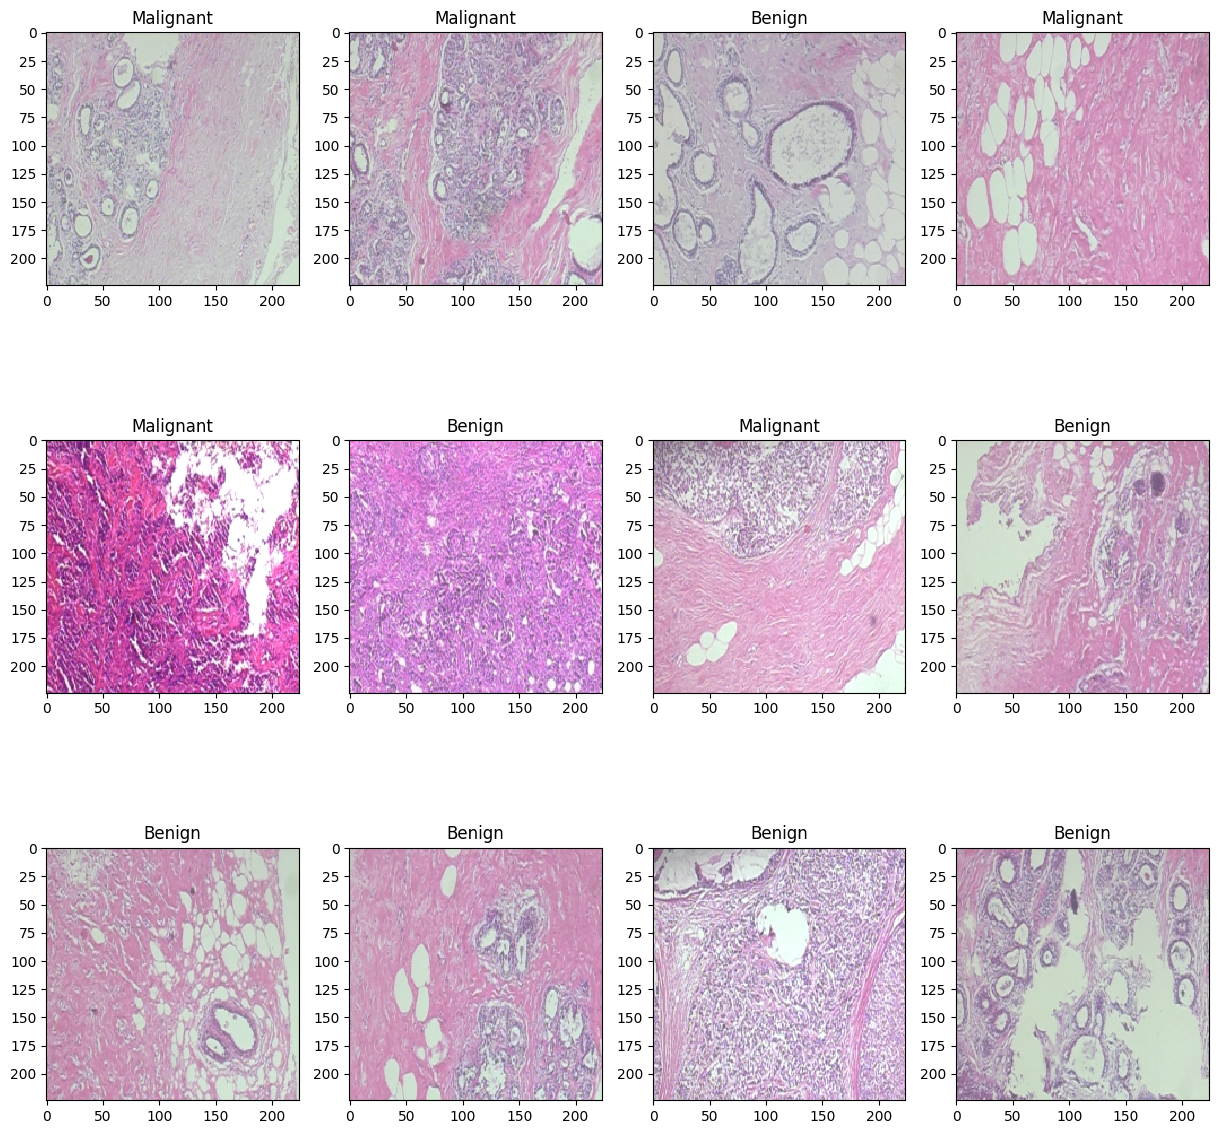

In [7]:
# Splitting data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Displaying sample images from the training set
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [8]:
 # Image preprocessing part - 2

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )


In [9]:

def build_model(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [10]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)


history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=7,
    validation_data=(x_val, y_val),
)

<ipython-input-10-ccb02f9ab9c5>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/7
11/11 [==============================] - 329s 21s/step - loss: 0.5926 - accuracy: 0.7749 - val_loss: 11.6125 - val_accuracy: 0.5625
Epoch 2/7
11/11 [==============================] - 255s 22s/step - loss: 0.3474 - accuracy: 0.8796 - val_loss: 681.8879 - val_accuracy: 0.4375
Epoch 3/7
11/11 [==============================] - 255s 21s/step - loss: 0.3714 - accuracy: 0.8377 - val_loss: 1781.2695 - val_accuracy: 0.4375
Epoch 4/7
11/11 [==============================] - 246s 21s/step - loss: 0.3090 - accuracy: 0.8429 - val_loss: 256.9941 - val_accuracy: 0.4375
Epoch 5/7
11/11 [==============================] - 254s 21s/step - loss: 0.2245 - accuracy: 0.8953 - val_loss: 4.6324 - val_accuracy: 0.5625
Epoch 6/7
11/11 [==============================] - 254s 21s/step - loss: 0.2206 - accuracy: 0.9110 - val_loss: 4.5116 - val_accuracy: 0.5625
Epoch 7/7
11/11 [==============================] - 254s 21s/step - loss: 0.2169 - accuracy: 0.9005 - val_loss: 15.4395 - val_accuracy: 0.5625


<Axes: >

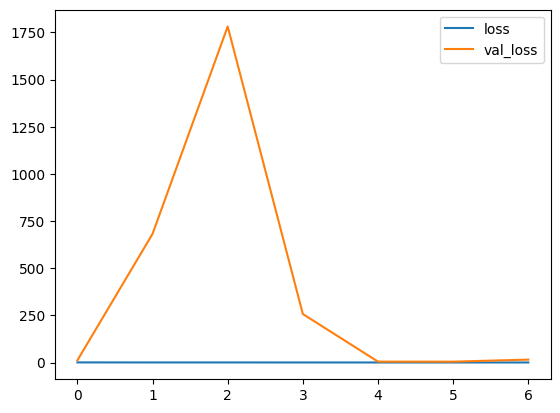

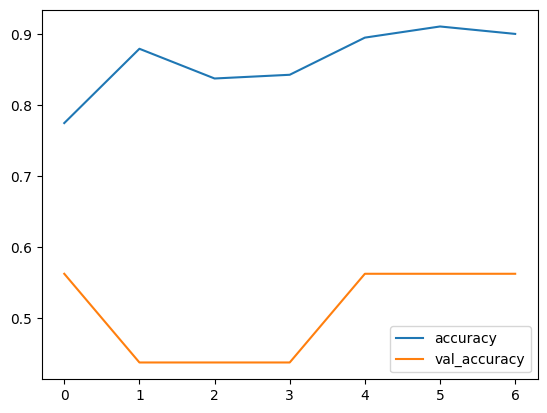

In [11]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [14]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(train_generator, open('drive/MyDrive/dataset/image-generator-model.pkl', 'wb'))
model.save('drive/MyDrive/dataset/breast-cancer-model.h5')